# Cross-sectional EDA of NARR

In [120]:
#pip install xarray netCDF4 requests
#os.chdir('/Users/vappaji/Documents/Capstone')
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from geodatasets import get_path
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import requests
import xarray as xr
from sklearn.cluster import KMeans

**First, looking at vertical profile for one month (October 2020)**

In [49]:
# pick a cross section (October 2020), combine vertical profile variables 
# Base URL 
base_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/"

# pressure vars 
variables = ["air", "hgt", "omega", "shum", "tke", "uwnd", "vwnd"]

# date is constant for now 
date = "202010"

ds = {}
for var in variables:
    url = f"{base_url}{var}.{date}.nc"
    ds[var] = xr.open_dataset(url)
    
# view datasets for each var like so: ds['hgt']

/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.

In [50]:
ds['air']

<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 2020-10-01 ... 2020-10-31T21:00:00
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Sat Feb 27 08:26:23 MST 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

Trying to merge with fire perim data (WIP)

In [43]:
#narr_crs = "EPSG:3347" #change fire data to NARR's lambert projection 
#fire_data_lambert = fire_data.to_crs(narr_crs)

In [44]:
# single cross section 

#datetime format 
#fire_data_lambert['initialdat'] = pd.to_datetime(fire_data_lambert['initialdat'], errors='coerce')

month = 10
#fire_sbst = fire_data_lambert[fire_data_lambert['initialdat'].dt.month == month]

In [37]:
#fire_start = pd.to_datetime(fire_data_lambert.iloc[0]['initialdat'])
#fire_end = pd.to_datetime(fire_data_lambert.iloc[0]['finaldate'])

NameError: name 'narr_data' is not defined

In [45]:
#fire_data['initialdat'] = pd.to_datetime(fire_data['initialdat'])

#october_fires = fire_data[fire_data['initialdat'].dt.month == 10]

In [48]:
for index, fire in october_fires.iterrows():
    fire_start = pd.to_datetime(fire['initialdat'])
    fire_end = pd.to_datetime(fire['finaldate'])
    
    # Get lat/lon bounds from the fire perimeter geometry
    lat_min, lon_min, lat_max, lon_max = fire['geometry'].bounds

    for var in ds.keys():
        narr = ds[var]  # NARR dataset for this variable
        narr_time_subset = narr.sel(time=slice(fire_start, fire_end))

        # Subset NARR spatially using lat/lon bounds
        narr_subset = narr_time_subset.where(
            (narr_time_subset['lat'] >= lat_min) & (narr_time_subset['lat'] <= lat_max) &
            (narr_time_subset['lon'] >= lon_min) & (narr_time_subset['lon'] <= lon_max),
            drop=True
        )

        # Perform further analysis with narr_subset (e.g., vertical profiles)
        print(f"NARR data for variable {var} around fire {index}:")
        print(narr_subset)

ValueError: Cannot apply_along_axis when any iteration dimensions are 0

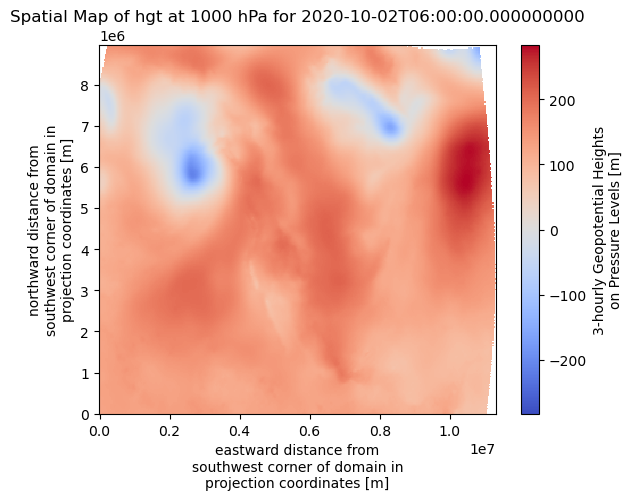

In [53]:
var = 'hgt'
narr_var = ds[var]

time_pt = narr_var.time[10]  # Adjust index as needed

# Plot a spatial map for a specific time and level
narr_spatial = narr_var.sel(time=time_pt, level=1000, method='nearest')  # e.g., 1000 hPa

# Plot the spatial map
narr_spatial['hgt'].plot(cmap='coolwarm')
plt.title(f"Spatial Map of {var} at 1000 hPa for {str(time_pt.values)}")
plt.show()

In [52]:
print(narr_var.coords)

Coordinates:
  * time     (time) datetime64[ns] 2020-10-01 ... 2020-10-31T21:00:00
  * level    (level) float32 1e+03 975.0 950.0 925.0 ... 175.0 150.0 125.0 100.0
  * y        (y) float32 0.0 3.246e+04 6.493e+04 ... 8.927e+06 8.96e+06
  * x        (x) float32 0.0 3.246e+04 6.493e+04 ... 1.126e+07 1.13e+07
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...


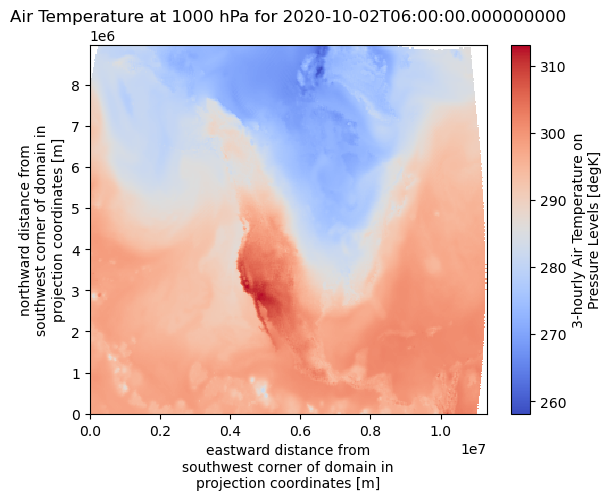

In [59]:
#temperature distribution at 10th time level in October (need to subset for western US)
# Choose the 'air' variable from your dataset
var = 'air'
narr_var = ds[var]

#print(narr_var['level'].values)
# set specific time and pressure level (here surface level: 1000 hPa)
time_pt = narr_var.time[10]  # Adjust index as needed
narr_spatial = narr_var.sel(time=time_pt, level=1000, method='nearest')  # 1000 hPa
narr_spatial_air = narr_spatial['air']

# Plot the spatial map for air temperature
narr_spatial_air.plot(cmap='coolwarm')
plt.title(f"Air Temperature at 1000 hPa for {str(time_pt.values)}")
plt.show()


**EDA of air temperature in particular**

Subset for the Western US

In [75]:
#subset for western US 
y_indices = np.where((narr_var['lat'] >= lat_min) & (narr_var['lat'] <= lat_max))[0]
x_indices = np.where((narr_var['lon'] >= lon_min) & (narr_var['lon'] <= lon_max))[1]

# Get the min and max indices for y and x
y_min, y_max = y_indices.min(), y_indices.max()
x_min, x_max = x_indices.min(), x_indices.max()

# Subset the data using the y and x indices
narr_west_us = narr_var.isel(y=slice(y_min, y_max), x=slice(x_min, x_max))

# Check the result
print(narr_west_us)

<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 203, x: 103)
Coordinates:
  * time               (time) datetime64[ns] 2020-10-01 ... 2020-10-31T21:00:00
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 2.37e+06 2.402e+06 ... 8.895e+06 8.927e+06
  * x                  (x) float32 3.214e+06 3.246e+06 ... 6.493e+06 6.525e+06
    lat                (y, x) float32 27.03 27.11 27.19 ... 83.27 83.14 83.0
    lon                (y, x) float32 -130.1 -129.8 -129.5 ... -55.02 -53.66
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544

In [129]:
time_pt = narr_west_us.time[10]  # Adjust index as needed
narr_spatial = narr_west_us.sel(time=time_pt, level=1000, method='nearest')

narr_spatial_air = narr_spatial['air']

narr_spatial_air.plot(cmap='coolwarm')
plt.title(f"Western US: Air Temperature at 1000 hPa for {str(time_pt.values)}")
plt.show()

AttributeError: 'dict' object has no attribute 'time'

**Time series of air temp**

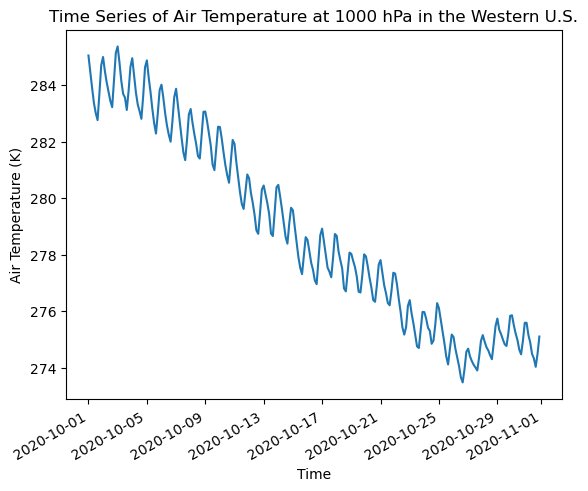

In [77]:
narr_west_us_subset = narr_west_us.sel(level=1000)

# Calculate the spatial mean of air temperature over the Western U.S.
air_mean_west_us = narr_west_us_subset['air'].mean(dim=['y', 'x'])
air_mean_west_us.plot()
plt.title("Time Series of Air Temperature at 1000 hPa in the Western U.S.")
plt.ylabel("Air Temperature (K)")
plt.xlabel("Time")
plt.show()

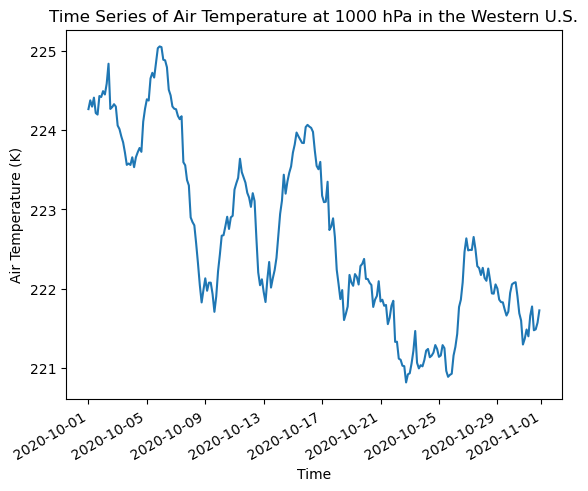

In [79]:
narr_west_us_subset = narr_west_us.sel(level=250)

# Calculate the spatial mean of air temperature over the Western U.S.
air_mean_west_us = narr_west_us_subset['air'].mean(dim=['y', 'x'])
air_mean_west_us.plot()
plt.title("Time Series of Air Temperature at 250 hPa in the Western U.S.")
plt.ylabel("Air Temperature (K)")
plt.xlabel("Time")
plt.show()

# Now the entire year of 2020

In [87]:
base_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/"

# pressure vars 
variables = ["air", "hgt", "omega", "shum", "tke", "uwnd", "vwnd"]

# date is constant for now 
dates = [f"2020{month:02d}" for month in range(1, 13)]

ds = {}
for var in variables:
    ds[var] = []
    for date in dates:
        url = f"{base_url}{var}.{date}.nc"
        ds[var].append(xr.open_dataset(url))
    

/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/opt/anaconda3/envs/columbia/lib/python3.9/s

In [88]:
ds['air']

[<xarray.Dataset>
 Dimensions:            (time: 248, level: 29, y: 277, x: 349)
 Coordinates:
   * time               (time) datetime64[ns] 2020-01-01 ... 2020-01-31T21:00:00
   * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
   * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
   * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
     lat                (y, x) float32 ...
     lon                (y, x) float32 ...
 Data variables:
     Lambert_Conformal  int32 ...
     air                (time, level, y, x) float32 ...
 Attributes: (12/17)
     Conventions:                     CF-1.2
     centerlat:                       50.0
     centerlon:                       -107.0
     comments:                        
     institution:                     National Centers for Environmental Predi...
     latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
     ...                              ...
     his

In [90]:
var = 'air'
narr_var = ds[var]

In [93]:
lat_min, lat_max = 30.0, 50.0
lon_min, lon_max = -125.0, -100.0

narr_west_us = []

for monthly_ds in narr_var:  

    y_indices = np.where((monthly_ds['lat'] >= lat_min) & (monthly_ds['lat'] <= lat_max))[0]
    x_indices = np.where((monthly_ds['lon'] >= lon_min) & (monthly_ds['lon'] <= lon_max))[1]

    y_min, y_max = y_indices.min(), y_indices.max()
    x_min, x_max = x_indices.min(), x_indices.max()
    
    narr_west_us.append(monthly_ds.isel(y=slice(y_min, y_max), x=slice(x_min, x_max)))




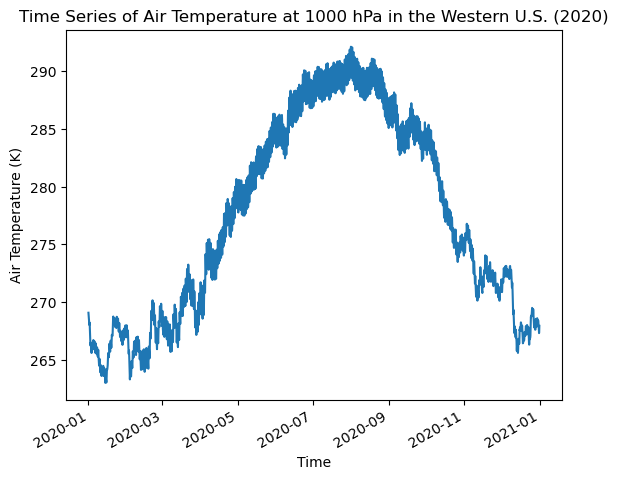

In [97]:


# Subset to the specific pressure level (1000 hPa) and calculate the spatial mean for each month
air_mean_west_us_list = []

for ds in narr_west_us:  # Loop over each dataset for all months
    if 'level' in ds.dims:  # Check if 'level' dimension exists
        air_mean_month = ds['air'].sel(level=1000).mean(dim=['y', 'x'])
        air_mean_west_us_list.append(air_mean_month)
    else:
        print("No level dimension in the dataset for a month.")

# Concatenate the results into a single DataArray along the time dimension
air_mean_west_us = xr.concat(air_mean_west_us_list, dim='time')

# Plot the time series of air temperature
air_mean_west_us.plot()
plt.title("Time Series of Air Temperature at 1000 hPa in the Western U.S. (2020)")
plt.ylabel("Air Temperature (K)")
plt.xlabel("Time")
plt.show()


**Patterns of air temperature correlate with frequency of wildfires**

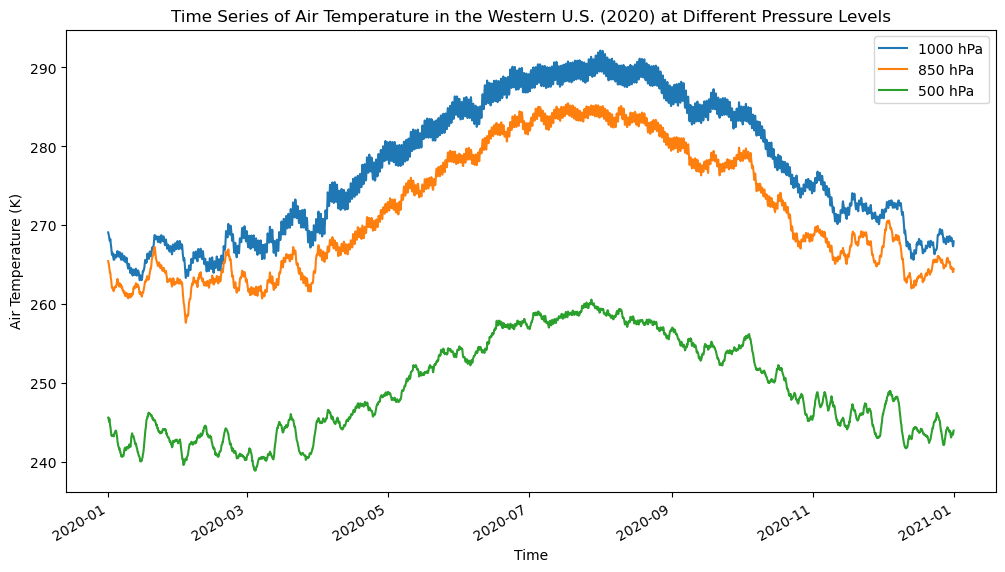

In [98]:

air_mean_west_us_1000 = []
air_mean_west_us_850 = []
air_mean_west_us_500 = []

# Loop over each dataset for all months
for ds in narr_west_us:
    if 'level' in ds.dims:  # Check if 'level' dimension exists
        # Calculate spatial mean for each pressure level
        air_mean_month_1000 = ds['air'].sel(level=1000).mean(dim=['y', 'x'])
        air_mean_month_850 = ds['air'].sel(level=850).mean(dim=['y', 'x'])
        air_mean_month_500 = ds['air'].sel(level=500).mean(dim=['y', 'x'])
        
        # Append the results to respective lists
        air_mean_west_us_1000.append(air_mean_month_1000)
        air_mean_west_us_850.append(air_mean_month_850)
        air_mean_west_us_500.append(air_mean_month_500)
    else:
        print("No level dimension in the dataset for a month.")

# Concatenate the results into single DataArrays along the time dimension
air_mean_west_us_1000 = xr.concat(air_mean_west_us_1000, dim='time')
air_mean_west_us_850 = xr.concat(air_mean_west_us_850, dim='time')
air_mean_west_us_500 = xr.concat(air_mean_west_us_500, dim='time')

# Plot the time series of air temperature for different levels
plt.figure(figsize=(12, 6))
air_mean_west_us_1000.plot(label='1000 hPa')
air_mean_west_us_850.plot(label='850 hPa')
air_mean_west_us_500.plot(label='500 hPa')
plt.title("Time Series of Air Temperature in the Western U.S. (2020) at Different Pressure Levels")
plt.ylabel("Air Temperature (K)")
plt.xlabel("Time")
plt.legend()
plt.show()


In [105]:
# sanity check is the data loaded properly 
base_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/"
variables = ["air", "hgt", "omega", "shum", "tke", "uwnd", "vwnd"]
dates = [f"2020{month:02d}" for month in range(1, 13)]

ds = {}
for var in variables:
    ds[var] = []
    for date in dates:
        url = f"{base_url}{var}.{date}.nc"
        try:
            dataset = xr.open_dataset(url)
            ds[var].append(dataset)
            print(f"Successfully loaded {var} for {date}.")
        except Exception as e:
            print(f"Error loading {url}: {e}")

# Check which variables have been loaded
for var in variables:
    if ds[var]:
        print(f"{var} loaded with {len(ds[var])} datasets.")
    else:
        print(f"{var} not loaded.")


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202001.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202002.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202003.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202004.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202005.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202006.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202007.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202008.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202009.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202010.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202011.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded air for 202012.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202001.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202002.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202003.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202004.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202005.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202006.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202007.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202008.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202009.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202010.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202011.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'hgt' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded hgt for 202012.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202001.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202002.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202003.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202004.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202005.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202006.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202007.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202008.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202009.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202010.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202011.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'omega' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded omega for 202012.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202001.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202002.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202003.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202004.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202005.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202006.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202007.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202008.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202009.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202010.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202011.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'shum' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded shum for 202012.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202001.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202002.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202003.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202004.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202005.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202006.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202007.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202008.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202009.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202010.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202011.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'tke' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded tke for 202012.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202001.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202002.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202003.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202004.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202005.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202006.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202007.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202008.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202009.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202010.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202011.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'uwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded uwnd for 202012.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202001.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202002.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202003.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202004.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202005.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202006.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202007.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202008.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202009.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202010.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Successfully loaded vwnd for 202011.
Successfully loaded vwnd for 202012.
air loaded with 12 datasets.
hgt loaded with 12 datasets.
omega loaded with 12 datasets.
shum loaded with 12 datasets.
tke loaded with 12 datasets.
uwnd loaded with 12 datasets.
vwnd loaded with 12 datasets.


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'vwnd' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


#Clustering 

**1-2 time steps per day to avoid redundancy** 

We consider 2 months for now (September and October; Sept is the month with highest wildfire frequency) 

In [116]:
months_of_interest = ['202009', '202010']

# Function to sample 1-2 times per day
def sample_time_steps(dataset, time_interval=12):
    # Select 1-2 time steps per day (e.g., every 12 hours)
    return dataset.sel(time=dataset.time[::time_interval])

# Combine September and October datasets for each variable with sampled time steps
ds_combined = {}
for var in variables:
    monthly_ds = [ds[var][i] for i, date in enumerate(dates) if date in months_of_interest]
    
    # Apply sampling to each dataset
    sampled_ds = [sample_time_steps(ds_per_month) for ds_per_month in monthly_ds]
    
    # Concatenate the sampled datasets along the time dimension
    ds_combined[var] = xr.concat(sampled_ds, dim='time')

In [118]:
stacked_data = {}
for var in ds_combined:
    stacked_data[var] = ds_combined[var].stack(points=("y", "x"))

In [126]:
air_stacked_var = air_stacked['air']  # Access 'air' variable

# Step 2: Convert to numpy array using .values
air_data_for_clustering = air_stacked_var.values  # Convert to numpy array

# Step 3: Handle NaNs in the data
air_data_for_clustering = np.nan_to_num(air_data_for_clustering)  # Replace NaNs with 0s

# Step 4: Check the shape of the array (time, level, points)
print(f"Shape of air_data_for_clustering: {air_data_for_clustering.shape}")

# Step 5: Reshape the data for clustering (points, time * levels)
n_time, n_levels, n_points = air_data_for_clustering.shape  # (time, level, points)
air_data_for_clustering_reshaped = air_data_for_clustering.transpose(2, 0, 1).reshape(n_points, n_time * n_levels)

# Step 6: Perform clustering (e.g., KMeans with 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(air_data_for_clustering_reshaped)

# Step 7: Add cluster labels to the stacked data
air_stacked['cluster'] = (("points",), kmeans.labels_)

# Step 8: Print or analyze the clusters
print(air_stacked['cluster'])

Shape of air_data_for_clustering: (41, 29, 96673)
<xarray.DataArray 'cluster' (points: 96673)>
array([2, 2, 2, ..., 1, 1, 1], dtype=int32)
Coordinates:
    lat      (points) float32 1.0 1.104 1.208 1.312 ... 47.22 46.93 46.64 46.35
    lon      (points) float32 -145.5 -145.3 -145.1 ... -2.718 -2.644 -2.57
  * points   (points) object MultiIndex
  * y        (points) float32 0.0 0.0 0.0 0.0 ... 8.96e+06 8.96e+06 8.96e+06
  * x        (points) float32 0.0 3.246e+04 6.493e+04 ... 1.126e+07 1.13e+07


In [127]:
print(air_stacked['cluster'])

<xarray.DataArray 'cluster' (points: 96673)>
array([2, 2, 2, ..., 1, 1, 1], dtype=int32)
Coordinates:
    lat      (points) float32 1.0 1.104 1.208 1.312 ... 47.22 46.93 46.64 46.35
    lon      (points) float32 -145.5 -145.3 -145.1 ... -2.718 -2.644 -2.57
  * points   (points) object MultiIndex
  * y        (points) float32 0.0 0.0 0.0 0.0 ... 8.96e+06 8.96e+06 8.96e+06
  * x        (points) float32 0.0 3.246e+04 6.493e+04 ... 1.126e+07 1.13e+07


/opt/anaconda3/envs/columbia/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


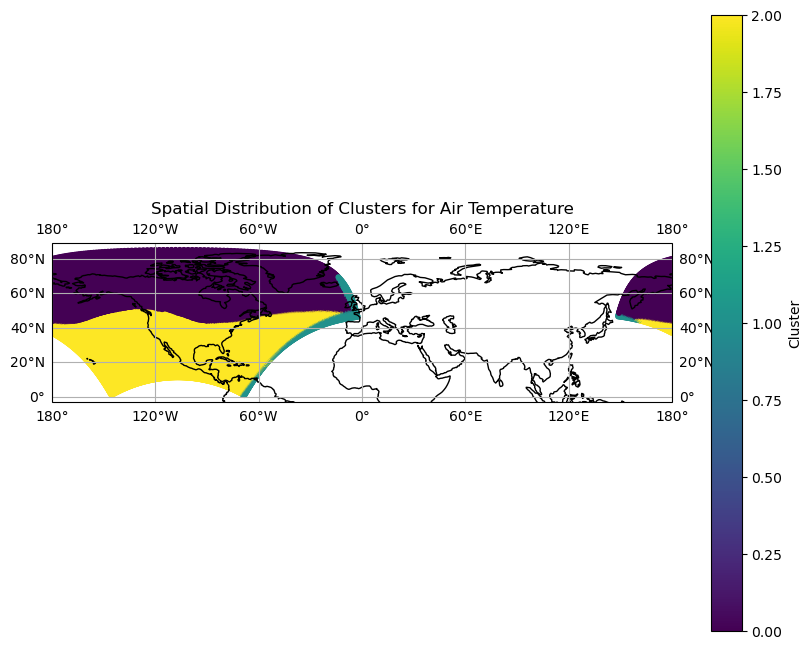

In [128]:
import cartopy.crs as ccrs

# Extract the lat, lon, and cluster data
lat = air_stacked['lat'].values
lon = air_stacked['lon'].values
clusters = air_stacked['cluster'].values

# Set up the map with Cartopy
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
scatter = ax.scatter(lon, lat, c=clusters, cmap='viridis', s=10, transform=ccrs.PlateCarree())

# Add coastlines, gridlines, and a colorbar
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.title('Spatial Distribution of Clusters for Air Temperature')
plt.show()